In [5]:
%%time

import torch
from torch2trt import TRTModule
import torchvision.transforms as transforms
import torch.nn.functional as F
import cv2
import PIL.Image
import numpy as np
from IPython.display import display
import ipywidgets
import traitlets
from jetbot import Camera, bgr8_to_jpeg
import time
from cameraX import CameraX

DO_DISPLAY_CAMERA = True
DO_RECORD_CAMERA = False
DO_MOTOR = False
DO_FPS = True

VIDEO_FILENAME = None
# VIDEO_FILENAME = '../models/videos/demo.avi'
# VIDEO_FILENAME = '../models/videos/result1.avi'
# VIDEO_FILENAME = '../models/videos/result2.avi'
# VIDEO_FILENAME = '../models/videos/result3.avi'
# VIDEO_FILENAME = '../models/videos/result4.avi'

# RTR_FILENAME = '../models/resnet18_ds545_0.0123_trt.pth'
# RTR_FILENAME = '../models/resnet34_ds545_0.0107_rtr.pth'
# RTR_FILENAME = '../models/resnet50_ds545_0.0098_trt.pth'
# RTR_FILENAME = '../models/resnet101_ds545_0.0099_trt.pth'

# RTR_FILENAME = '../models/densenet121_ds545_0.0145_trt.pth'
# RTR_FILENAME = '../models/densenet169_ds545_0.00856_trt.pth'

RTR_FILENAME = '../models/resnet18_DS755_E15_0.0088_trt.pth'
# RTR_FILENAME = '../models/resnet34_DS755_E15_0.0089_trt.pth'
# RTR_FILENAME = '../models/resnet50_DS755_E15_0.0076_trt.pth'

# RTR_FILENAME = '../models/resnext50_32x4d_DS755_E15_0.0079_trt.pth'
# RTR_FILENAME = '../models/wide_resnet50_2_DS755_E15_0.0075_trt.pth'
# RTR_FILENAME = '../models/mobilenet_v2_DS755_E15_0.0084_trt.pth'
# RTR_FILENAME = '../models/mobilenet_v2_DS755_E30_0.0076_trt.pth'

# 載入TRT
device = torch.device('cuda')
model_trt = TRTModule()
model_trt.load_state_dict(torch.load(RTR_FILENAME))

CPU times: user 852 ms, sys: 276 ms, total: 1.13 s
Wall time: 1.25 s


<All keys matched successfully>

In [6]:
mean = torch.Tensor([0.485, 0.456, 0.406]).cuda().half()
std = torch.Tensor([0.229, 0.224, 0.225]).cuda().half()

def preprocess(image):
    image = PIL.Image.fromarray(image)
    image = transforms.functional.to_tensor(image).to(device).half()
    image.sub_(mean[:, None, None]).div_(std[:, None, None])
    return image[None, ...]

if VIDEO_FILENAME:
    cap = cv2.VideoCapture(VIDEO_FILENAME)
    if not cap.isOpened():  # check if we succeeded
        print('Error!')
    camera = CameraX(**{'cap': cap})
else:
#     cap = None
#     camera = CameraX()
    
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():  # check if we succeeded
        print('Error!')
    print('format:', cap.get(cv2.CAP_PROP_FORMAT))
    camera = CameraX(**{'cap': cap})

if DO_DISPLAY_CAMERA:
    image_widget = ipywidgets.Image()

if DO_MOTOR:
    from jetbot import Robot
    robot = Robot()

speed_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.25, description='speed gain')
steering_gain_slider = ipywidgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.07, description='steering gain')
steering_dgain_slider = ipywidgets.FloatSlider(min=0.0, max=0.5, step=0.001, value=0.11, description='steering kd')
steering_bias_slider = ipywidgets.FloatSlider(min=-0.3, max=0.3, step=0.01, value=0.0, description='steering bias')
x_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='x')
y_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='y')
steering_slider = ipywidgets.FloatSlider(min=-1.0, max=1.0, description='steering')
speed_slider = ipywidgets.FloatSlider(min=0, max=1.0, orientation='vertical', description='speed')

UI_list = [ipywidgets.VBox([speed_gain_slider, steering_gain_slider,
                                         steering_dgain_slider, steering_bias_slider]),
                                         y_slider, speed_slider,
                                         ipywidgets.VBox([x_slider, steering_slider])]
if DO_DISPLAY_CAMERA:
    UI_list.insert(0, image_widget)

display(ipywidgets.HBox(UI_list))

angle = 0.0
angle_last = 0.0

if DO_RECORD_CAMERA:
    out = cv2.VideoWriter('../models/result.avi', cv2.VideoWriter_fourcc(*'MJPG'), 30.0, (224, 224))
else:
    out = None

FPS_list = []
# drop_frames = 0
# num_drop_frames = -1
def execute(change):
    global angle, angle_last, min_FPS, max_FPS, FPS_list
    
#     global drop_frames, num_drop_frames
#     # 前面N張Frames捨棄不用
#     if num_drop_frames <= drop_frames:
#         num_drop_frames += 1
#         return
    
    start = time.time()
    image = change['new']
    if image is None:
        return
    image = cv2.resize(image, (224, 224))
    
    xy = model_trt(preprocess(image)).detach().float().cpu().numpy().flatten()
    x = xy[0]
    y = (0.5 - xy[1]) / 2.0
    
    x_slider.value = x
    y_slider.value = y
    speed_slider.value = speed_gain_slider.value
    angle = np.arctan2(x, y)
    pid = angle * steering_gain_slider.value + (angle - angle_last) * steering_dgain_slider.value
    angle_last = angle
    
    steering_slider.value = pid + steering_bias_slider.value
    left_motor = max(min(speed_slider.value + steering_slider.value, 1.0), 0.0)
    right_motor = max(min(speed_slider.value - steering_slider.value, 1.0), 0.0)
    
    # 移動馬達
    if DO_MOTOR:
        robot.left_motor.value = left_motor
        robot.right_motor.value = right_motor
    
    # 顯示攝影機
    if DO_DISPLAY_CAMERA:
        image_widget.value = cv2.imencode('.jpg', image)[1].tobytes()
    # 紀錄這一張圖片
    if DO_RECORD_CAMERA:
        out.write(image)
    # 顯示預測位置
    cv2.putText(image, 'X: {:.2f}'.format(x), (10, 30), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, 'Y: {:.2f}'.format(y), (10, 60), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    # 顯示馬達轉速
    cv2.putText(image, 'LM: {:.2f}'.format(left_motor), (10, 90), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, 'RM: {:.2f}'.format(right_motor), (10, 120), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
    
    # 計算FPS
    if DO_FPS:
        fps = 1 / (time.time() - start)
#         FPS_list.append(fps)
#         cv2.putText(image, 'FPS: {:.0f}'.format(fps), (10, 210), cv2.FONT_HERSHEY_TRIPLEX, 1, (0, 255, 255), 1, cv2.LINE_AA)
#         print('\ravgFPS:{:.0f} FPS:{:.0f} '.format(sum(FPS_list)/len(FPS_list),fps), end='')
        print('\rFPS:{:.0f} '.format(fps), end='')
        
camera.observe(execute, names='value')
# while(True):
#     try:
#         v = camera.value
#         if v is None:
#             print('\nEnd!')
#             break
#         execute({'new': v})
#     except KeyboardInterrupt:
#         print('\nStop!')
#         break
# time.sleep(0.1)  # add a small sleep to make sure frames have finished processingn
# if DO_MOTOR:
#     robot.stop()
# camera.stop()
# if cap:
#     cap.release()
# if out:
#     out.release()

format: 0.0
Shape: 640.0 480.0 FPS: 30.0
Buffer: 0.0


avgFPS:15 maxFPS:25 minFPS:7 FPS:11 

In [7]:
camera.unobserve(execute, names='value')
time.sleep(0.1)  # add a small sleep to make sure frames have finished processing
if DO_MOTOR:
    robot.stop()
camera.stop()
if cap:
    cap.release()
if out:
    out.release()

avgFPS:15 maxFPS:25 minFPS:7 FPS:8 

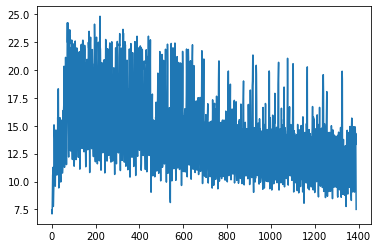

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(FPS_list);